In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = "/content/cleaned_prompt_scores.csv"

In [3]:
df = pd.read_csv(data)

print(f"Dataset Loaded. Total Rows: {len(df)}")
print(f"Columns found: {df.columns.tolist()}")

Dataset Loaded. Total Rows: 13531
Columns found: ['prompt', 'score']


In [5]:
missing_text = df['prompt'].isnull().sum()
missing_label = df['score'].isnull().sum()

print(f"Missing Prompts: {missing_text}")
print(f"Missing Scores:  {missing_label}")


Missing Prompts: 0
Missing Scores:  0


In [6]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')

mean_val = df['score'].mean()
median_val = df['score'].median()
mode_val = df['score'].mode()[0]
std_dev = df['score'].std()

print(f"Mean Score:   {mean_val:.2f}")
print(f"Median Score: {median_val:.2f}")
print(f"Mode Score:   {mode_val:.2f}")
print(f"Std Deviation:{std_dev:.2f}")

print("\nScore Percentiles:")
print(df['score'].quantile([0.25, 0.5, 0.75, 0.90]))

Mean Score:   46.41
Median Score: 53.00
Mode Score:   1.00
Std Deviation:27.34

Score Percentiles:
0.25    26.000000
0.50    53.000000
0.75    68.000000
0.90    76.779047
Name: score, dtype: float64


In [7]:
out_of_range = df[(df['score'] < 0) | (df['score'] > 100)]
print(f"Scores out of range (0-100): {len(out_of_range)}")
if not out_of_range.empty:
    print(out_of_range.head(3))

Scores out of range (0-100): 0


In [8]:
df['text_len'] = df['prompt'].astype(str).apply(len)

In [9]:
short_prompts = df[df['text_len'] < 5]
print(f"Suspiciously short prompts (< 5 chars): {len(short_prompts)}")
if not short_prompts.empty:
    print(short_prompts[['text', 'label']].head(3))

Suspiciously short prompts (< 5 chars): 0


In [10]:
avg_len = df['text_len'].mean()
max_len = df['text_len'].max()
print(f"Average Prompt Length (chars): {avg_len:.0f}")
print(f"Max Prompt Length (chars):     {max_len}")

Average Prompt Length (chars): 101
Max Prompt Length (chars):     2337


In [12]:
low_score  = df[df['score'] <= 25]
mid_score  = df[(df['score'] > 25) & (df['score'] < 80)]
high_score = df[df['score'] >= 80]

print(f"Original Distribution -> Low: {len(low_score)}, Mid: {len(mid_score)}, High: {len(high_score)}")

Original Distribution -> Low: 3355, Mid: 9516, High: 660


In [14]:
target_count = len(mid_score)
target_count

9516

In [15]:
from sklearn.utils import resample
if len(high_score) > 0:
    df_high_upsampled = resample(high_score,
                                 replace=True,
                                 n_samples=target_count,
                                 random_state=42)
else:
    df_high_upsampled = high_score

if len(low_score) > 0:
    df_low_upsampled = resample(low_score,
                                replace=True,
                                n_samples=target_count,
                                random_state=42)
else:
    df_low_upsampled = low_score

In [17]:
df_balanced = pd.concat([df_low_upsampled, mid_score, df_high_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
print(f"\nNew Balanced Count: {len(df_balanced)}")
print(f"New Distribution -> Low: {len(df_balanced[df_balanced['score']<=25])}, Mid: {len(mid_score)}, High: {len(df_balanced[df_balanced['score']>=80])}")


New Balanced Count: 28548
New Distribution -> Low: 9516, Mid: 9516, High: 9516


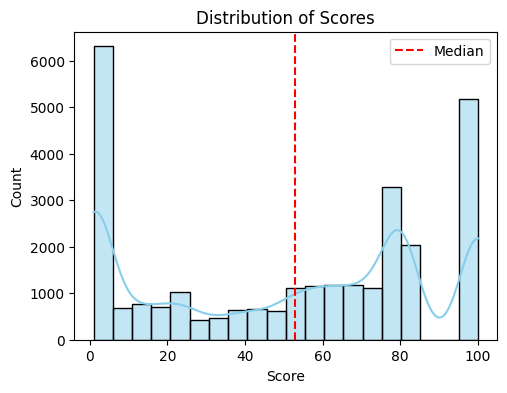

In [20]:
plt.figure(figsize=(12, 4))

#Score Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_balanced['score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.axvline(median_val, color='red', linestyle='--', label='Median')
plt.legend()

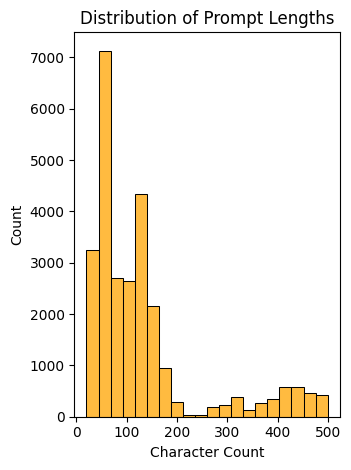

In [24]:
#Text Length Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_balanced[df_balanced['text_len'] < 500]['text_len'], bins=20, color='orange')
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Character Count")

plt.tight_layout()
plt.show()

In [25]:
df_balanced = df_balanced.rename(columns={"prompt": "text", "score": "label"})

In [26]:
df_final = df_balanced[['text', 'label']]

In [27]:
df_final.to_csv("final_clean_bert_data.csv", index=False)